In [1]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

# os
import os

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# tf
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, Input, Activation, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2
from keras.utils.vis_utils import plot_model

In [2]:
# Import data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Mushroom Classification Project/mushrooms.csv')

#### Data Topology:

-	cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
-	cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
-	cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
-	bruises: bruises=t,no=f
-	odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
-	gill-attachment: attached=a,descending=d,free=f,notched=n
-	gill-spacing: close=c,crowded=w,distant=d
-	gill-size: broad=b,narrow=n
-	gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
-	stalk-shape: enlarging=e,tapering=t
-	stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
-	stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
-	stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
-	stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
-	stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
-	veil-type: partial=p,universal=u
-	veil-color: brown=n,orange=o,white=w,yellow=y
-	ring-number: none=n,one=o,two=t
-	ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
-	spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
-	population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
-	habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d


In [4]:
# Categorical encoding

for feat in df.columns:
    # extract unique column values
    vals = np.unique(df[feat].values)
    # fit labelencoder
    le = LabelEncoder()
    le.fit(df[feat])
    # transform dataset
    df[feat] = le.transform(df[feat])

In [5]:
# Extract list of training features
tfeatures = np.array(df.columns)[1:]
features = np.array(df.columns)

In [6]:
# Split into train/target
_target = df.pop('class')
_train = df

In [7]:
# Train size
train_size = 6499

# Make train/test data
x_train = {}
x_test = {}
y_train = []
y_test = []

In [8]:
# Populate x_train, x_test
for f in tfeatures:
    x_train[f] = _train[f][:train_size+1]
    x_test[f] = _train[f][train_size:]

In [9]:
# Populate y_train, y_test
y_train = _target[:train_size+1]
y_test = _target[train_size:]

In [10]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [11]:
# Custom loss function
def neg_log_likelihood(targets, estimate):
    return -estimate.log_prob(targets)

In [12]:
# BNN Model

# Prior weights will remain fixed and untrained
#   mean = 0
#   std-dev = 1
def prior_weights_model(kernel_size, bias_size, dtype = None):
    units = kernel_size + bias_size
    pw = Sequential()
    pw.add(
        tfp.layers.DistributionLambda(
            lambda x: tfd.MultivariateNormalDiag(loc = tf.zeros(units), 
                                                 scale_diag = tf.ones(units) )
        ) 
    )
    return pw

# Posterior weights will be trained and unfixed
#   learnable params are mean, variance, and covariance
def posterior_inference_model(kernel_size, bias_size, dtype = None):
    units = kernel_size + bias_size
    pi = Sequential()
    pi.add(
        tfp.layers.VariableLayer(
            tfp.layers.MultivariateNormalTriL.params_size(units), dtype = dtype
        )
    )
    pi.add(
        tfp.layers.MultivariateNormalTriL(units)
    )
    return pi

# This function will produce an input tensor for each feature extracted from the df
#   keras.layers.Input produces a keras tensor with a specific feature name
#   this will allow us to later quantify inference for each feature
def populate_input_tensors(_features = tfeatures):
    inputs = {}
    for f in _features:
        inputs[f] = Input(name = f, shape = (1,), dtype = tf.float32)
    return inputs

# training_size = len(x_train)
def _BNN(n_units = 2, lr = 0.001, training_size = 6500, hidden_units = 10, activ = 'sigmoid'):
    input_layers = populate_input_tensors()
    feature_layers = keras.layers.concatenate( list(input_layers.values()) )
    feature_layers = keras.layers.BatchNormalization()(feature_layers)

    for u in np.full(shape = n_units, fill_value = hidden_units):
        feature_layers = tfp.layers.DenseVariational(
            units = u,
            make_posterior_fn = posterior_inference_model,
            make_prior_fn = prior_weights_model,
            kl_weight = 1 / training_size,
            activation = activ)(feature_layers)

    # Probabilistic output model
    #   Dense layer: used to produce distribution parameters
    #   IndependentBernoulli: used for binary classification
    dist_params = Dense(units = 2)(feature_layers)
    output_layers = tfp.layers.IndependentBernoulli(2)(dist_params)

    model = keras.Model(inputs = input_layers, outputs = output_layers)
    model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = lr), 
                  metrics = [keras.metrics.RootMeanSquaredError()], 
                  loss = neg_log_likelihood)
    return model

In [13]:
params = {
    'bnn_a1':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':6, 'lr':0.005, 'batch_size':64, 'activ':'sigmoid', 'label':'BNN A - 64', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_a2':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':6, 'lr':0.005, 'batch_size':128, 'activ':'sigmoid', 'label':'BNN A - 128', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_a3':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':6, 'lr':0.005, 'batch_size':256, 'activ':'sigmoid', 'label':'BNN A - 256', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_a4':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':6, 'lr':0.005, 'batch_size':512, 'activ':'sigmoid', 'label':'BNN A - 512', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_b1':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':8, 'lr':0.005, 'batch_size':64, 'activ':'sigmoid', 'label':'BNN B - 64', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_b2':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':8, 'lr':0.005, 'batch_size':128, 'activ':'sigmoid', 'label':'BNN B - 128', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_b3':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':8, 'lr':0.005, 'batch_size':256, 'activ':'sigmoid', 'label':'BNN B - 256', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''},
    'bnn_b4':{'model':'', 'function':_BNN, 'n_units':2, 'hidden_units':8, 'lr':0.005, 'batch_size':512, 'activ':'sigmoid', 'label':'BNN B - 512', 'history':'', 'RMSE_train':'', 'RMSE_test':'', 'predict':'', 'cv_results':''}
}

In [14]:
# Parameters
n_epoches = 200

In [15]:
# Train cross-validated NN model
for k in params.keys():
    tf.random.set_seed(0)
    model = params[k]['function'](n_units = params[k]['n_units'], lr = params[k]['lr'], training_size = len(y_train), hidden_units = params[k]['hidden_units'])
    params[k]['history'] = model.fit(x = x_train, y = y_train, validation_data = (x_test, y_test), epochs = n_epoches, batch_size = params[k]['batch_size'], shuffle = True)
    params[k]['model'] = model

Epoch 1/200
102/102 [==============================] - 7s 14ms/step - loss: 1.3899 - root_mean_squared_error: 0.7030 - val_loss: 1.5079 - val_root_mean_squared_error: 0.7185
Epoch 2/200
102/102 [==============================] - 1s 6ms/step - loss: 1.3750 - root_mean_squared_error: 0.6995 - val_loss: 1.4750 - val_root_mean_squared_error: 0.7145
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 1.3451 - root_mean_squared_error: 0.6969 - val_loss: 1.3967 - val_root_mean_squared_error: 0.7021
Epoch 4/200
102/102 [==============================] - 1s 7ms/step - loss: 1.2211 - root_mean_squared_error: 0.6598 - val_loss: 1.1896 - val_root_mean_squared_error: 0.6537
Epoch 5/200
102/102 [==============================] - 1s 6ms/step - loss: 0.9653 - root_mean_squared_error: 0.5922 - val_loss: 0.7573 - val_root_mean_squared_error: 0.5329
Epoch 6/200
102/102 [==============================] - 1s 6ms/step - loss: 0.7186 - root_mean_squared_error: 0.5039 - val_loss: 0.6776

In [16]:
# Prediction on test and train data with NN models
for k in params.keys():
    print('Model: %s' % (k))
    model = params[k]['model']

    params[k]['train_pd'] = model.predict(x_train, verbose = 1)
    params[k]['test_pd'] = model.predict(x_test, verbose = 1)

Model: bnn_a1
51/51 [==============================] - 0s 3ms/step
Model: bnn_a2
51/51 [==============================] - 0s 3ms/step
Model: bnn_a3
51/51 [==============================] - 0s 3ms/step
Model: bnn_a4
51/51 [==============================] - 0s 3ms/step
Model: bnn_b1
51/51 [==============================] - 0s 3ms/step
Model: bnn_b2
51/51 [==============================] - 0s 3ms/step
Model: bnn_b3
51/51 [==============================] - 0s 3ms/step
Model: bnn_b4
51/51 [==============================] - 0s 3ms/step


In [17]:
# Calculate prediction means and stddevs
for k in params.keys():
    params[k]['train_means'] = np.array([np.mean(x) for x in params[k]['train_pd']])
    params[k]['train_stdev'] = np.array([np.std(x) for x in params[k]['train_pd']])
    params[k]['test_means'] = np.array([np.mean(x) for x in params[k]['test_pd']])
    params[k]['test_stdev'] = np.array([np.std(x) for x in params[k]['test_pd']])

In [18]:
# Calculate test, train RMSE
for k in params.keys():
    params[k]['RMSE_train'] = mean_squared_error(y_train, params[k]['train_means'], squared = False)
    params[k]['RMSE_test'] = mean_squared_error(y_test, params[k]['test_means'], squared = False)

In [19]:
# Average deviations
for k in params.keys():
    params[k]['avg_train_stdev'] = params[k]['train_stdev'].mean()
    params[k]['avg_test_stdev'] = params[k]['test_stdev'].mean()

In [20]:
# Metrics

for k in params.keys():
    print('Model: %s' % (params[k]['label']))
    print('\tTrain RMSE: %f' % params[k]['RMSE_train'])
    print('\tTest RMSE: %f' % params[k]['RMSE_test'])
    print('\tAvg Test StDev: %f' % params[k]['avg_train_stdev'])
    print('\tAvg Train StDev: %f' % params[k]['avg_test_stdev'])

Model: BNN A - 64
	Train RMSE: 0.137281
	Test RMSE: 0.326049
	Avg Test StDev: 0.012769
	Avg Train StDev: 0.040308
Model: BNN A - 128
	Train RMSE: 0.154422
	Test RMSE: 0.292470
	Avg Test StDev: 0.014769
	Avg Train StDev: 0.036923
Model: BNN A - 256
	Train RMSE: 0.170181
	Test RMSE: 0.288764
	Avg Test StDev: 0.019769
	Avg Train StDev: 0.047385
Model: BNN A - 512
	Train RMSE: 0.207086
	Test RMSE: 0.273721
	Avg Test StDev: 0.025154
	Avg Train StDev: 0.041538
Model: BNN B - 64
	Train RMSE: 0.160048
	Test RMSE: 0.289828
	Avg Test StDev: 0.017385
	Avg Train StDev: 0.036308
Model: BNN B - 128
	Train RMSE: 0.188924
	Test RMSE: 0.277904
	Avg Test StDev: 0.022462
	Avg Train StDev: 0.041231
Model: BNN B - 256
	Train RMSE: 0.215103
	Test RMSE: 0.287429
	Avg Test StDev: 0.031615
	Avg Train StDev: 0.066769
Model: BNN B - 512
	Train RMSE: 0.231882
	Test RMSE: 0.271463
	Avg Test StDev: 0.034308
	Avg Train StDev: 0.057538


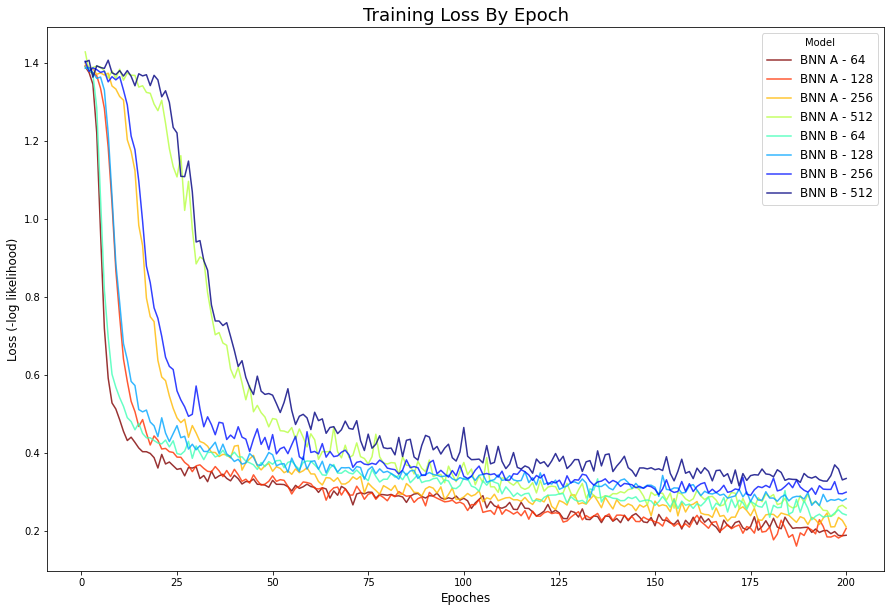

In [21]:
# Plot training loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 8))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['loss'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
#plt.xscale('log')
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('Loss (-log likelihood)', fontsize = 12)
plt.title('Training Loss By Epoch', fontsize = 18)

plt.show()

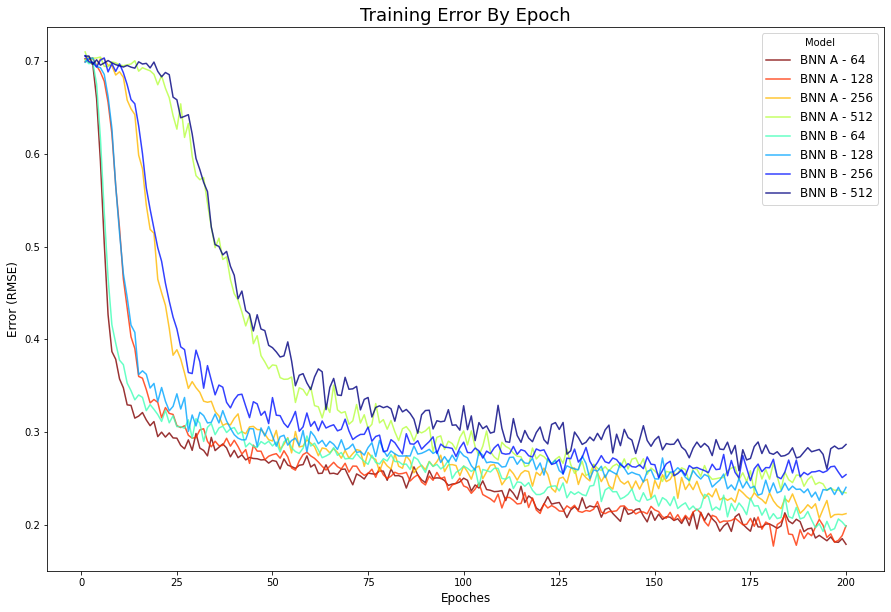

In [22]:
# Plot training error by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 8))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['root_mean_squared_error'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('Error (RMSE)', fontsize = 12)
plt.title('Training Error By Epoch', fontsize = 18)

plt.show()

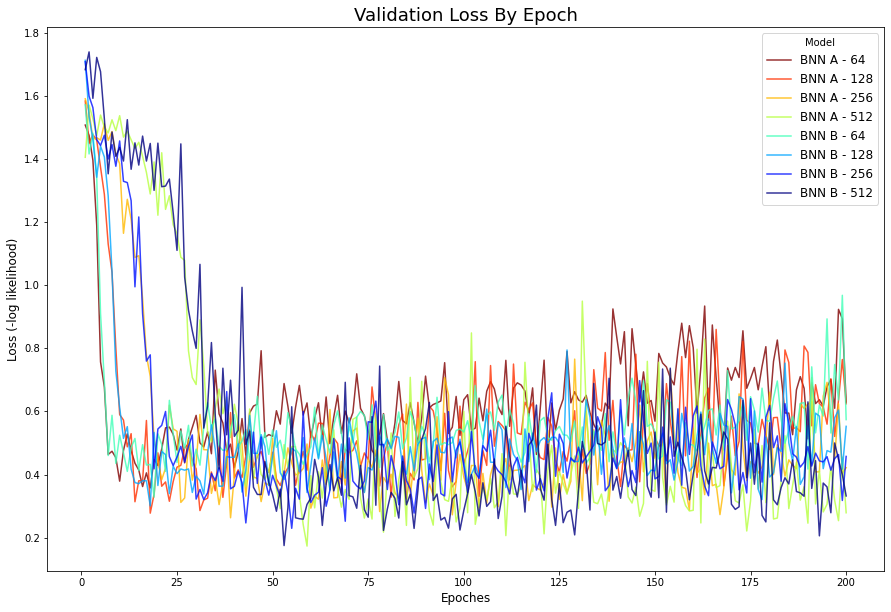

In [23]:
# Plot validation loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 8))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['val_loss'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('Loss (-log likelihood)', fontsize = 12)
plt.title('Validation Loss By Epoch', fontsize = 18)

plt.show()

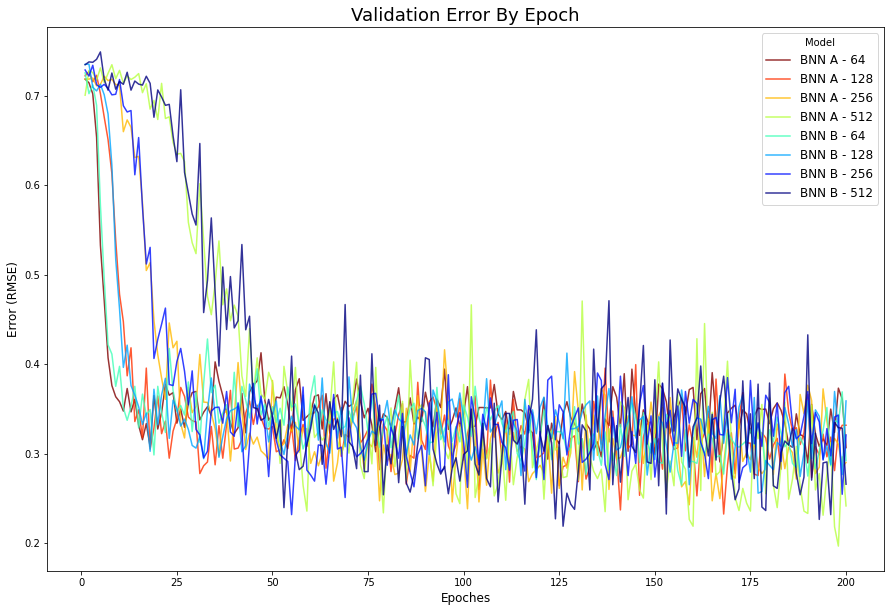

In [24]:
# Plot validation error by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(1, 0, 8))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['val_root_mean_squared_error'], color = colors[i], label = params[k]['label'], alpha = 0.8)
    i += 1
    
plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('Error (RMSE)', fontsize = 12)
plt.title('Validation Error By Epoch', fontsize = 18)

plt.show()

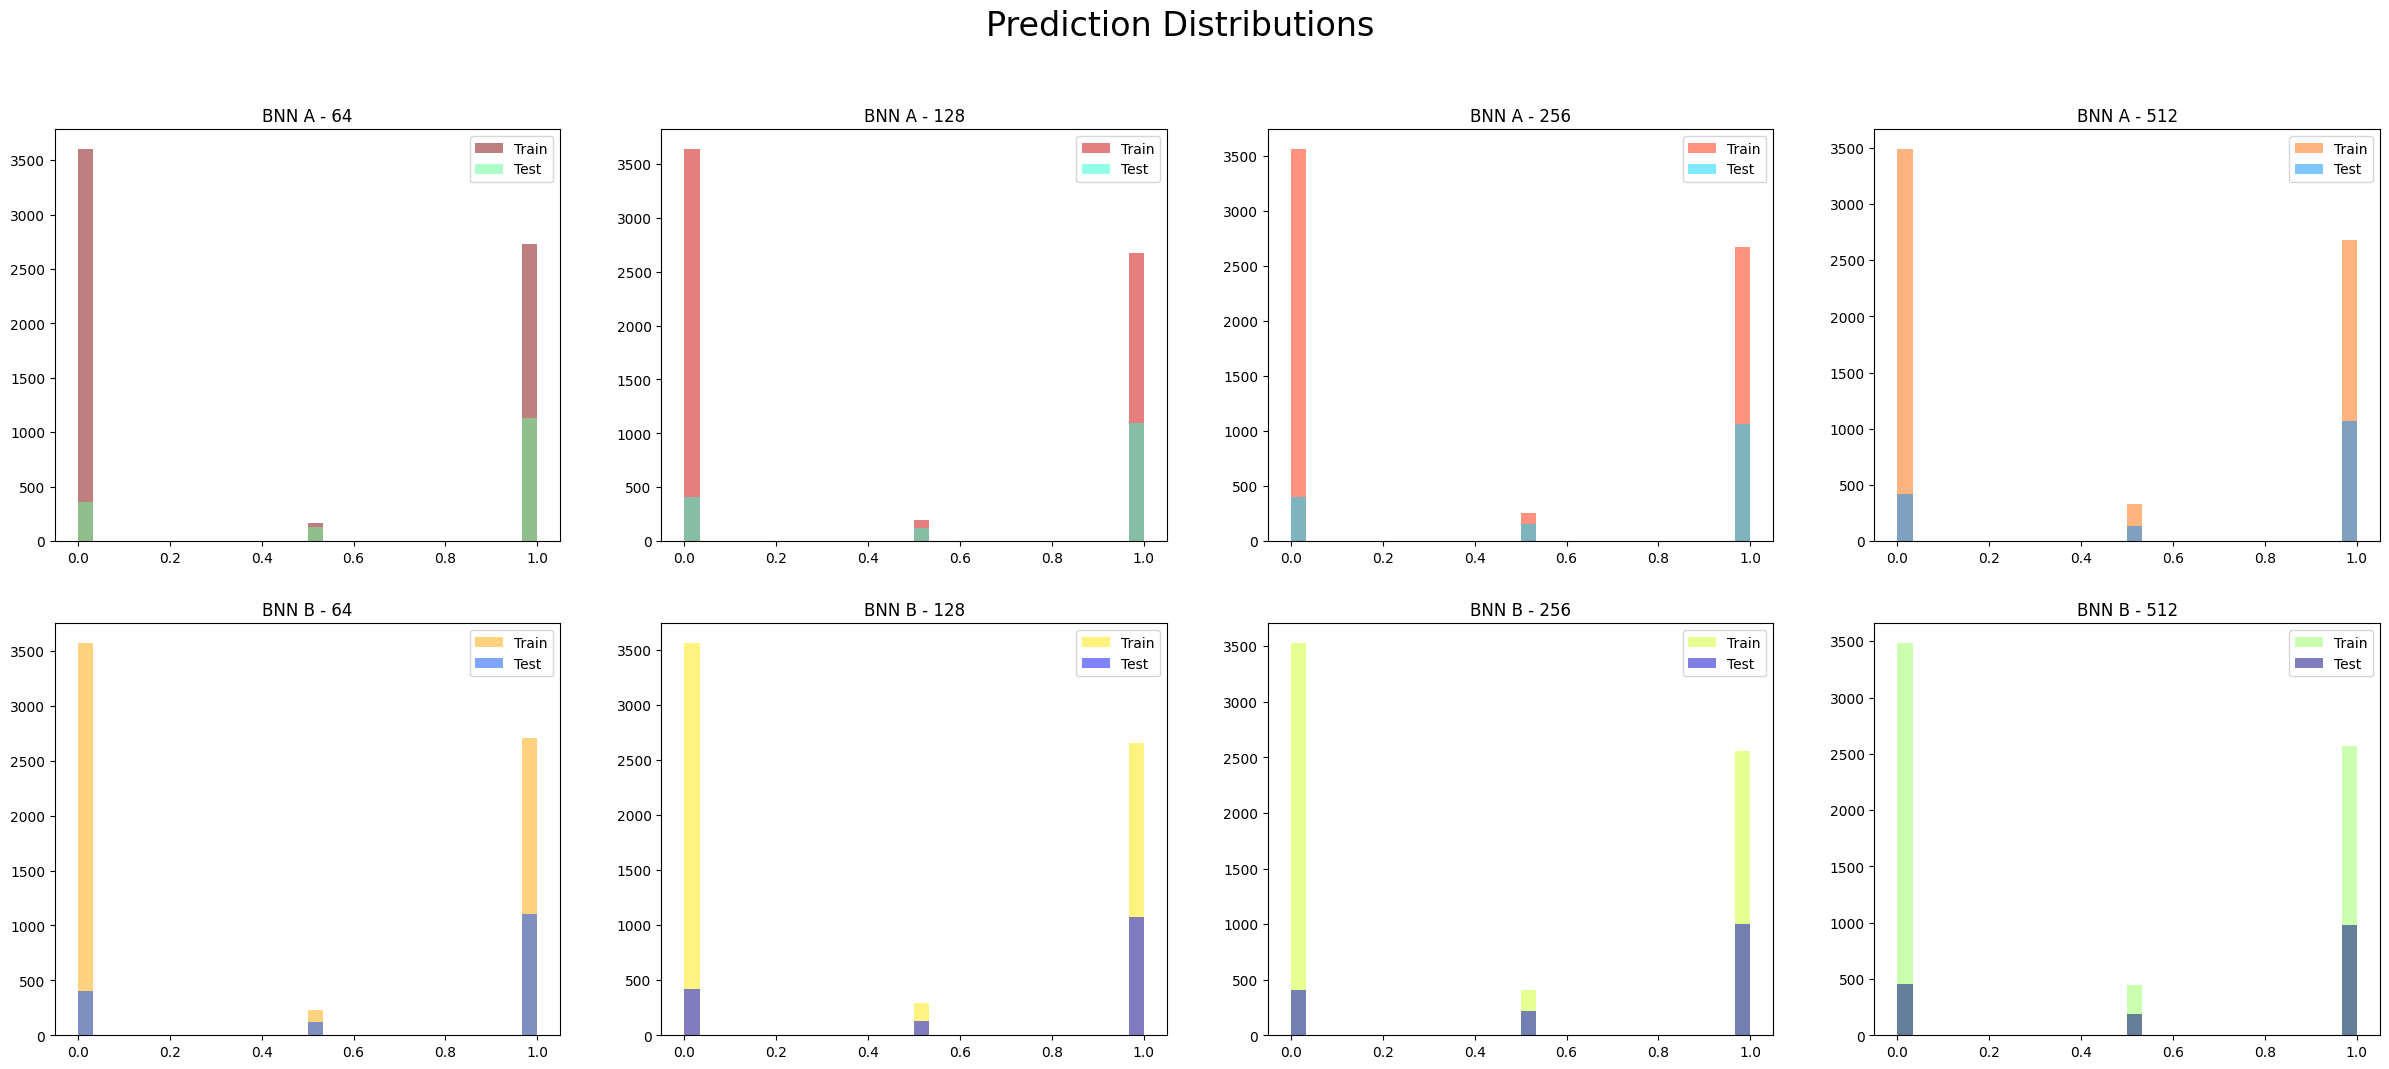

In [25]:
# Plot distributions
fig, ax = plt.subplots(2, 4, figsize = (30, 12), dpi = 100)
colors = pl.cm.jet(np.linspace(1, 0, 16))
c = 0

k = list(params.keys())

# Plot train
for row in ax:
    for col in row:
        col.hist(params[k[c]]['train_means'], bins = 30, color = colors[c], alpha = 0.5, label = 'Train')
        col.set_title(params[k[c]]['label'])
        c += 1

# Plot test
for row in ax:
    for col in row:
        col.hist(params[k[c-8]]['test_means'], bins = 30, color = colors[c], alpha = 0.5, label = 'Test')
        col.set_title(params[k[c-8]]['label'])
        col.legend(loc = 'best')
        c += 1


# Plot test
fig.suptitle('Prediction Distributions', fontsize = 24)

plt.show()